In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
df = pd.read_excel('Lat_long_SM_RZSM.xlsx')

# Features and target
features = ['SAND', 'SILT', 'CLAY', 'HC', 'SSM']
target = 'SSM(RZ)'

In [6]:
df[features].head()

,SAND,SILT,CLAY,HC,SSM
0,66.0,26.773196,7.226804,3.0365,0.150318
1,66.6,24.294651,9.105349,4.7645,0.152638
2,71.0,20.128265,8.871735,3.9005,0.147877
3,44.9,32.860160,22.239840,0.2850,0.162709
4,74.4,22.214143,3.385857,0.3758,0.162709


In [7]:
#removing outliers
def remove_outliers_all_features(df):
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers_all_features(df)

In [8]:
X = df[features]
y = df[target]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_scaled = scaler.fit_transform(X)

# Initial split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

# Split the remaining 30% into 15% val and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, None],  # None allows full depth
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}


# Initialize model
rf = RandomForestRegressor(random_state=42)

# Grid Search using validation set
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
X_tune = np.concatenate([X_train, X_val])
y_tune = np.concatenate([y_train, y_val])

grid_search.fit(X_tune, y_tune)


# Best model
best_rf = grid_search.best_estimator_

# Train on training set using best parameters
best_rf.fit(X_train, y_train)

# Predict on test set
y_pred = best_rf.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Best Parameters from Validation Set:", grid_search.best_params_)
print(f"\nTest MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


Best Parameters from Validation Set: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Test MAE: 0.0007
Test RMSE: 0.0015
Test R²: 0.8867


In [9]:
y_test

,SSM(RZ)
4,0.148953
28,0.137113
47,0.148953
40,0.140409
49,0.142911
9,0.148953
30,0.141019


In [10]:
y_pred

array([0.14889651, 0.14110189, 0.14902812, 0.14061617, 0.14233142,
       0.14884349, 0.14102841])

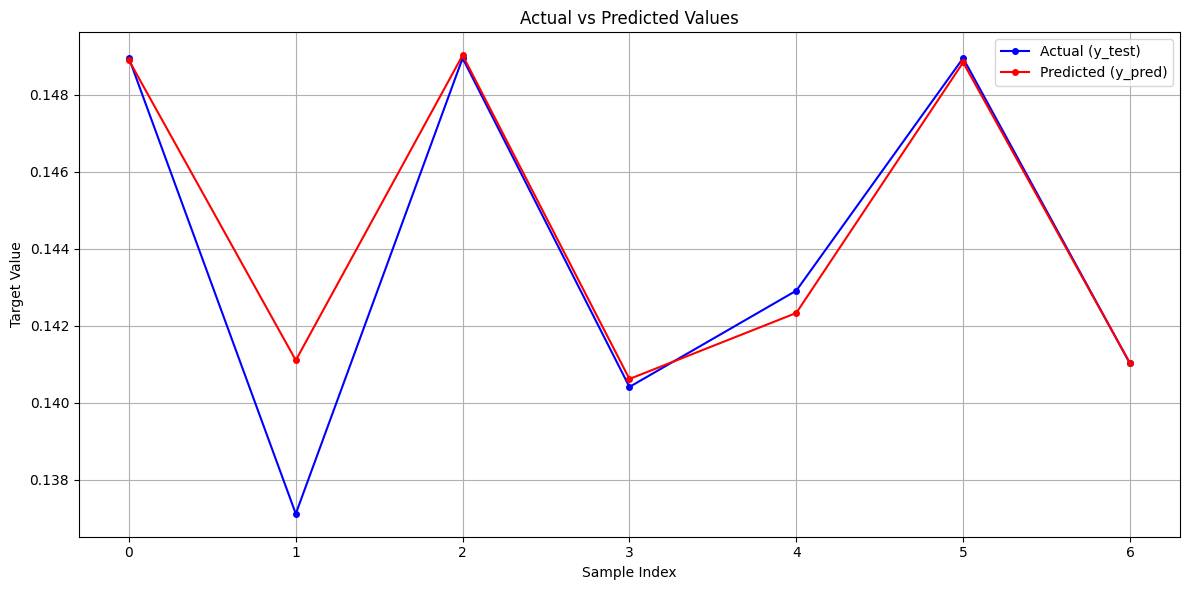

In [11]:
import matplotlib.pyplot as plt

# Create a line plot with dots
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, 'bo-', label='Actual (y_test)', markersize=4)
plt.plot(y_pred, 'ro-', label='Predicted (y_pred)', markersize=4)

plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


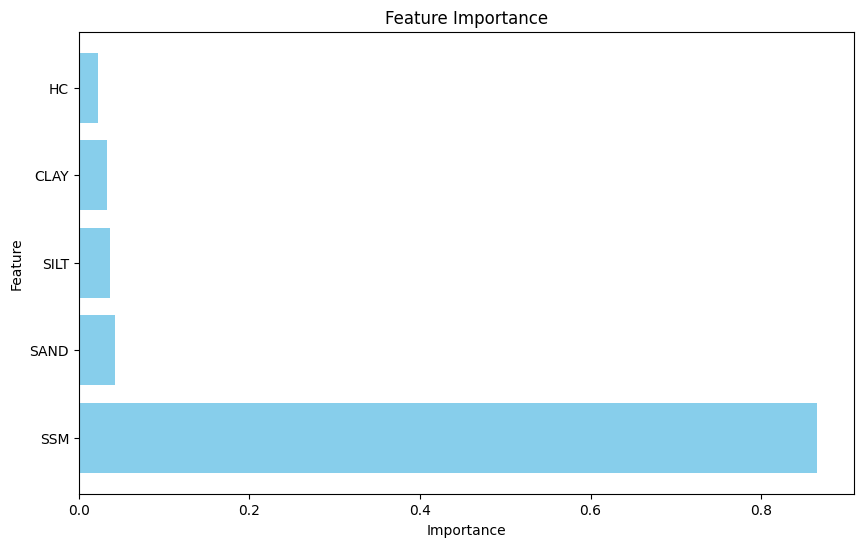

In [12]:
# Plot Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
#features = ['SAND', 'SILT', 'CLAY', 'HC', 'surface soil moisture']
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[indices], align='center', color='skyblue')
plt.yticks(range(len(features)), np.array(features)[indices])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


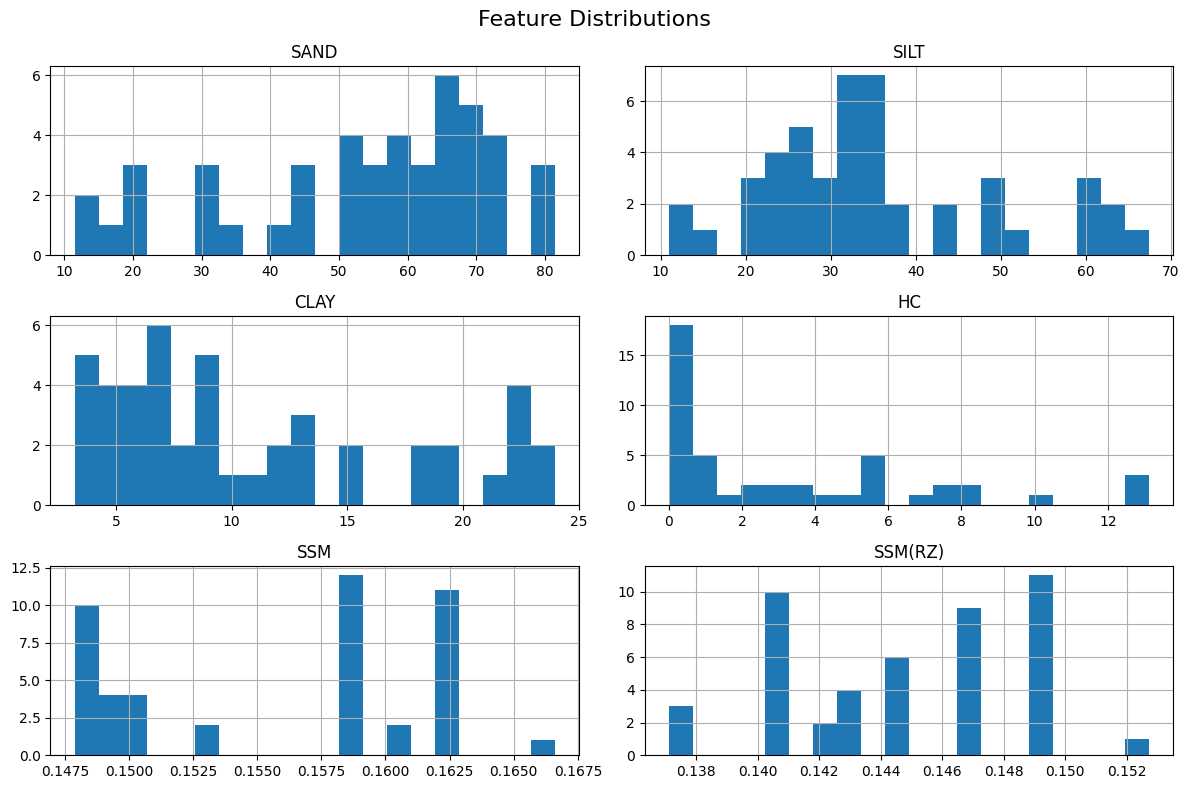

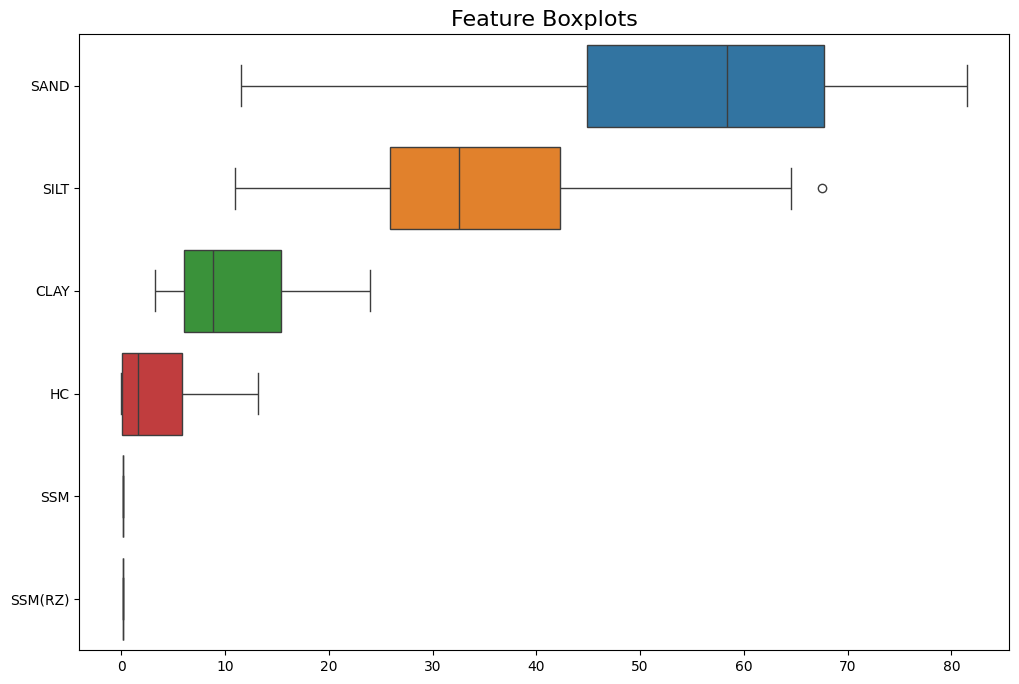

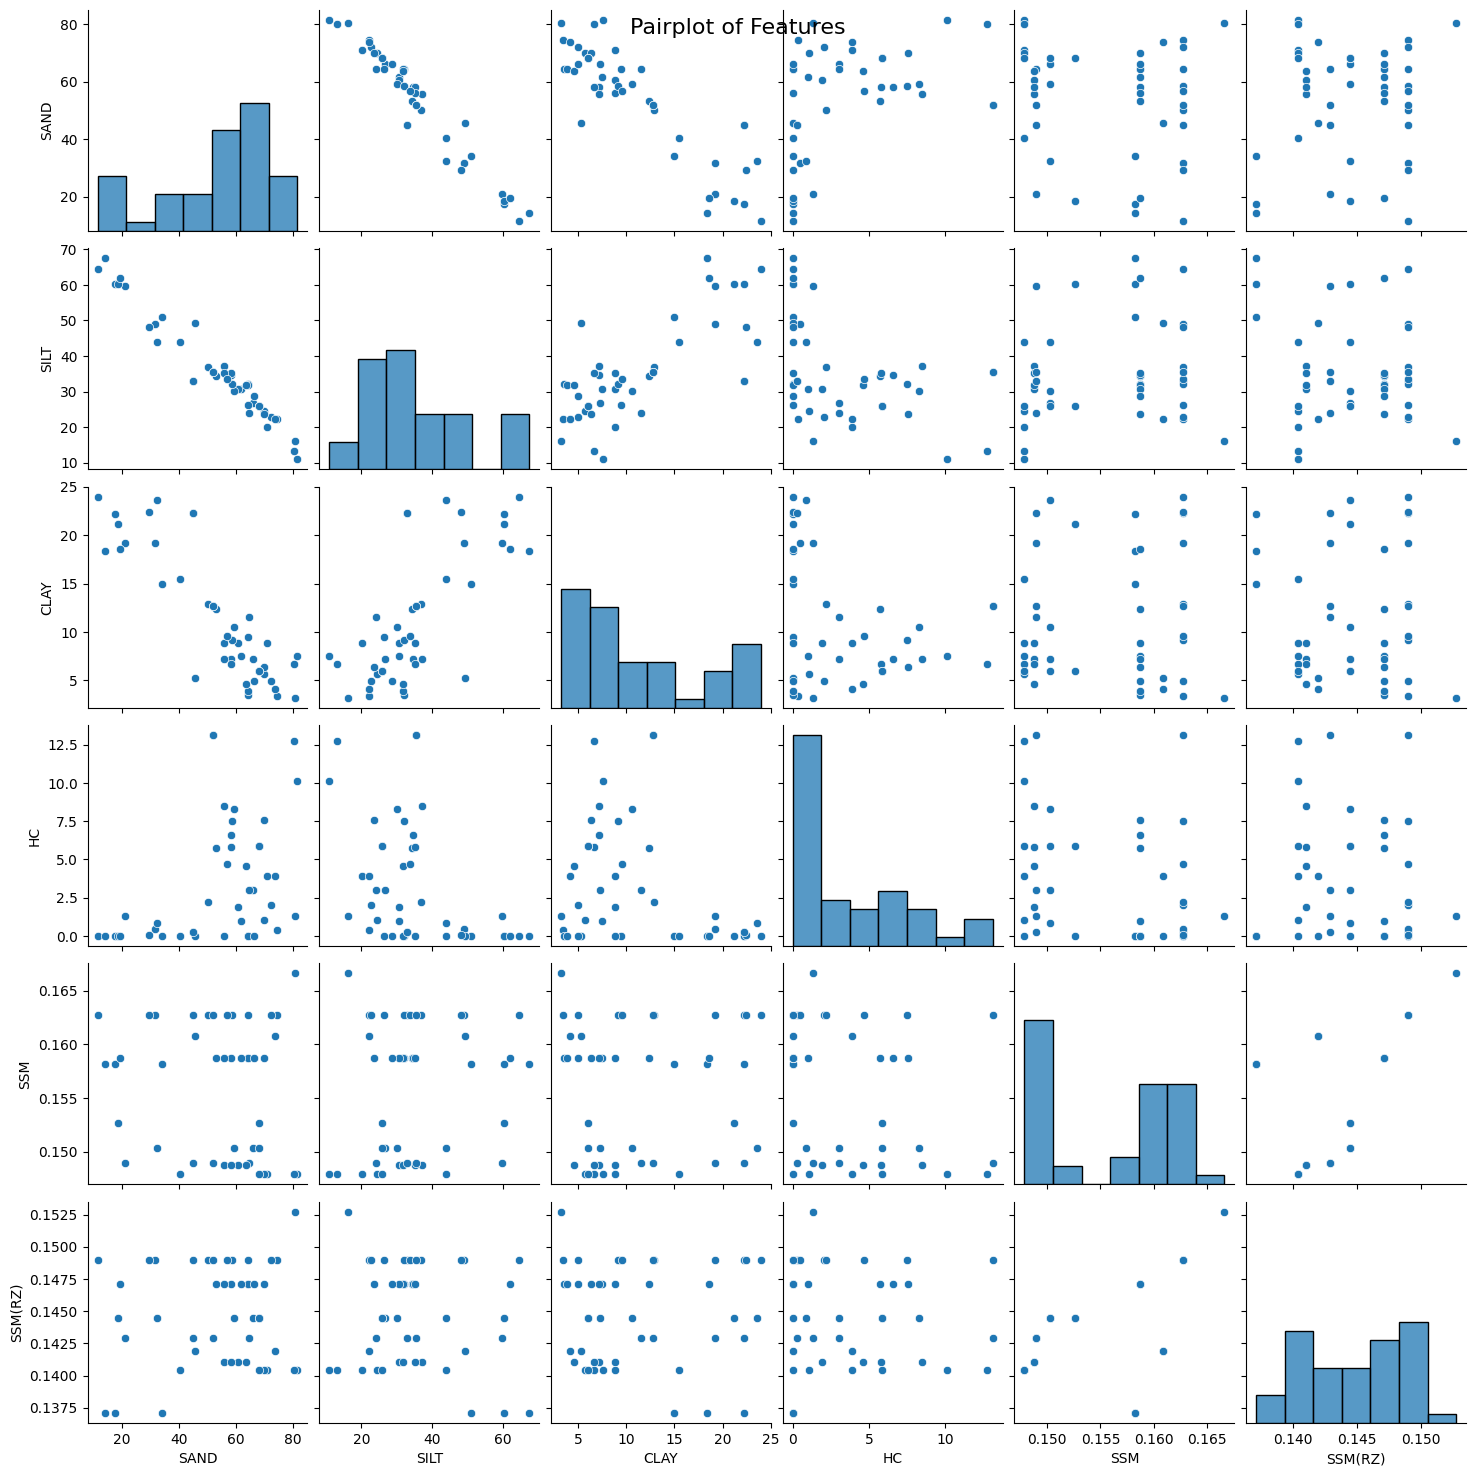

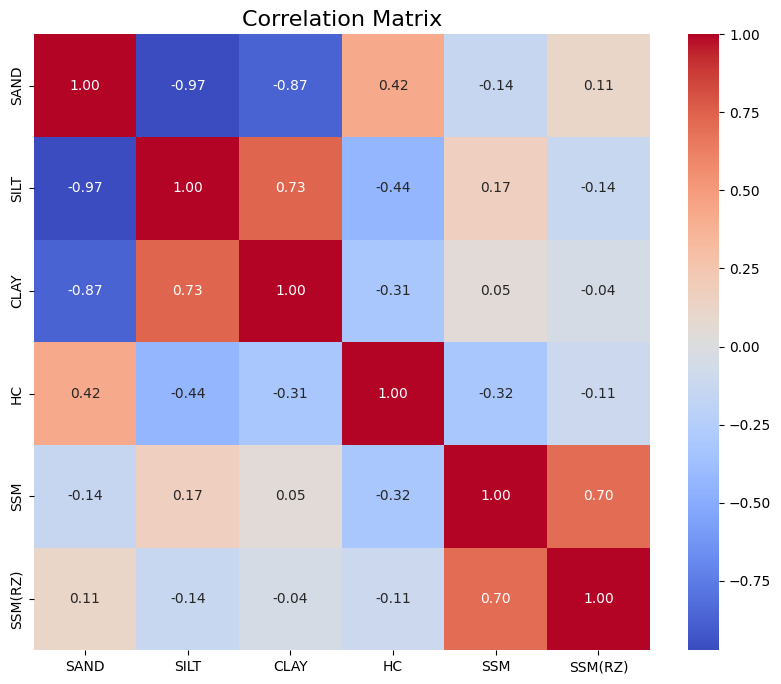

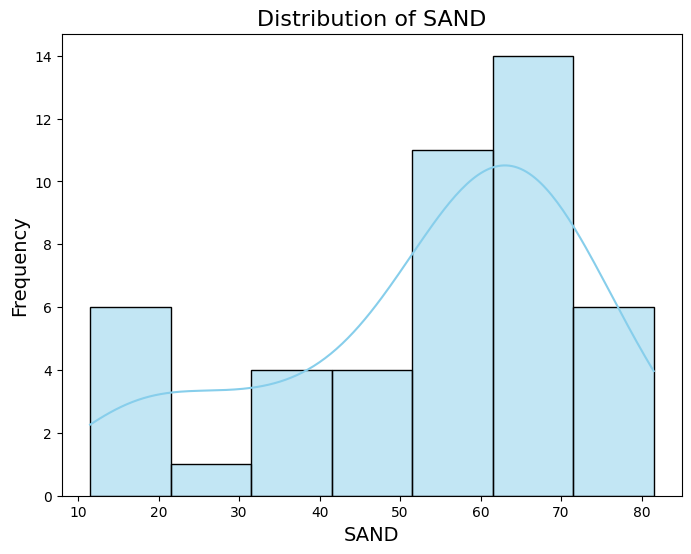

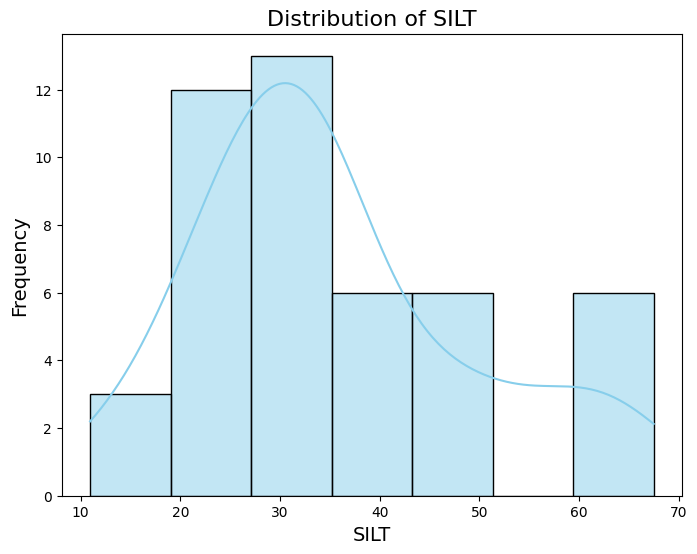

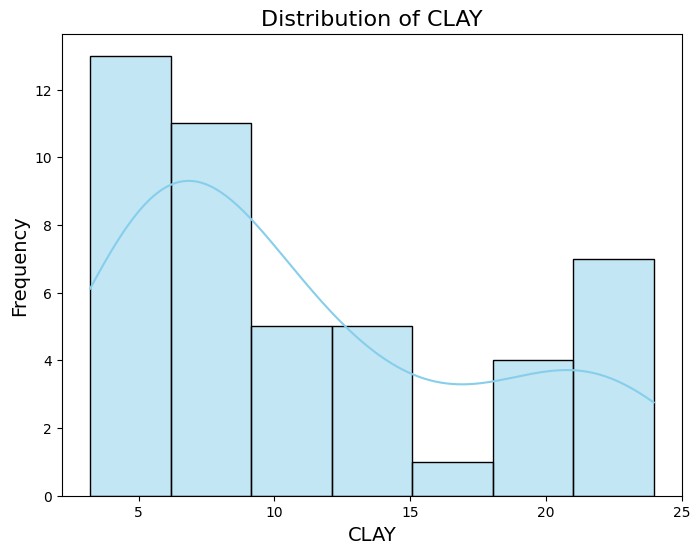

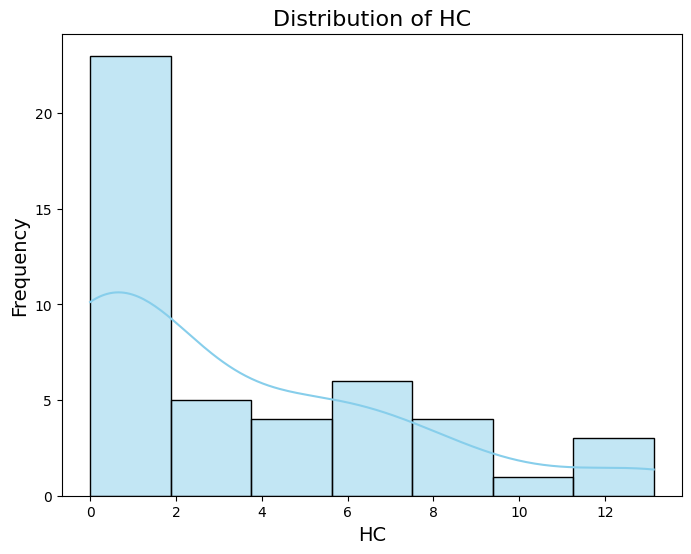

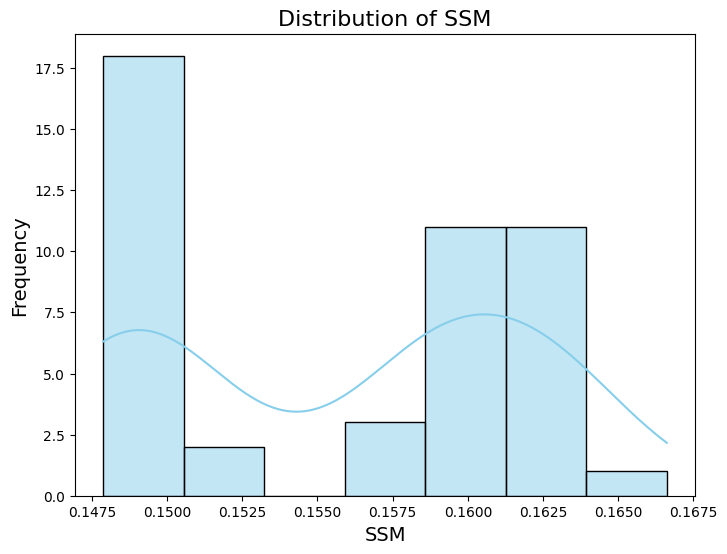

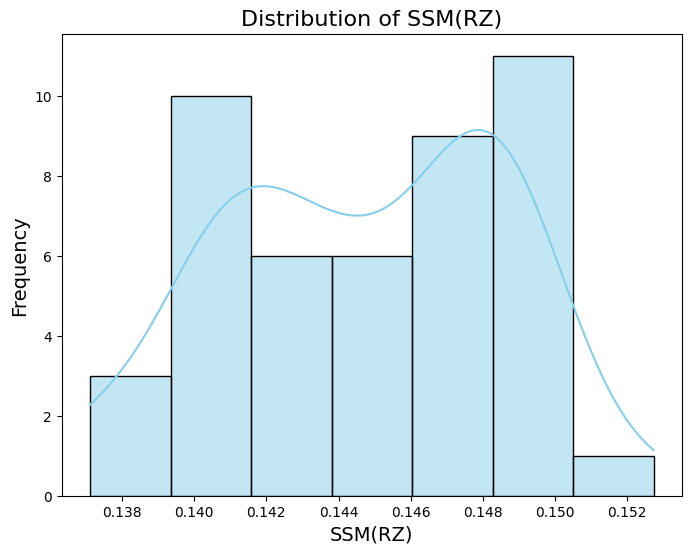

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Feature list
features = ['SAND', 'SILT', 'CLAY', 'HC', 'SSM','SSM(RZ)']

# 1. Plot histograms for all features
df[features].hist(bins=20, figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# 2. Plot boxplots for all features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[features], orient="h")
plt.title("Feature Boxplots", fontsize=16)
plt.show()

# 3. Plot pairplot to explore relationships
sns.pairplot(df[features])
plt.suptitle("Pairplot of Features", fontsize=16)
plt.show()

# 4. Plot correlation matrix heatmap
corr_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

# 5. Plot individual distributions for each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[feature], kde=True, color="skyblue")
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 0 to 53
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LATITUDE   46 non-null     float64
 1   LONGITUDE  46 non-null     float64
 2   SAND       46 non-null     float64
 3   SILT       46 non-null     float64
 4   CLAY       46 non-null     float64
 5   BD         46 non-null     float64
 6   HC         46 non-null     float64
 7   SSM        46 non-null     float64
 8   SSM(RZ)    46 non-null     float64
dtypes: float64(9)
memory usage: 3.6 KB
